_Will Kaufman, September 30 2020_

The following analyses were done on a water sample in a Bruker 9.4T magnet.

In [76]:
import os
import  numpy as np
from scipy.optimize import curve_fit
import nmrglue as ng

import matplotlib.pyplot as plt

In [77]:
def plot_spectrum(data_p, indices=None):
    x = np.linspace(data_p[0]['procs']['F1P'],
                    data_p[0]['procs']['F2P'],
                    data_p[0]['procs']['FTSIZE'])
    y = data_p[1]
    if indices is not None:
        x = x[indices[0]:indices[1]]
        y = y[indices[0]:indices[1]]
    plt.plot(x, y)

In [78]:
def read_raw(data_dir, expno):
    return ng.bruker.read(os.path.join(data_dir, str(expno)))

In [79]:
def read_processed(data_dir, expno):
    return ng.bruker.read_pdata(os.path.join(data_dir, str(expno), 'pdata', '1'))

## Estimating $\pi/2$ pulse length

To estimate the $\pi/2$ pulse length (with fixed power of 15W), a series of experiments were run that applied a pulse with lengths varying from 0 to 40$\mu$s. The resulting signal amplitudes were then plotted versus pulse length, and a $\sin$ function
$$
S(t_\text{pulse}) = S_0 \sin(\alpha t_\text{pulse})
$$
was fitted to the data by estimating $S_0$ and $\alpha$.
The pulse length for a $\pi/2$ pulse can then be determined by
$$
t_{\pi/2} = \frac{\pi}{2 \alpha}
$$

In [80]:
data_dir = '../data/2020-09-22/tarfile'

The signal amplitude is calculated by integrating the spectrum (Fourier transform of the free induction decay).

In [81]:
amplitudes = np.zeros((40,))
stds = np.zeros((40,))
for i in range(40):
    data_p = read_processed(data_dir, 3014 + i)
    amplitudes[i] = np.sum(data_p[1])
    stds[i] = np.std(data_p[1][:100]) * data_p[1].shape[0]

In [82]:
t = np.linspace(0, 40e-6, 40)
fit = curve_fit(lambda t, S0, alpha: S0 * np.sin(alpha * t),
                xdata=t,
                ydata=amplitudes, sigma=stds)

The estimates and standard errors for $S_0$ and $\alpha$ are given below.

In [83]:
estimates = fit[0]
std_errs = np.sqrt(np.diag(fit[1]))
print(estimates)  # estimates
print(std_errs)  # standard errors

[422746.88112094  53619.67614156]
[84.81468522 16.45298503]


Text(0, 0.5, 'Signal amplitude')

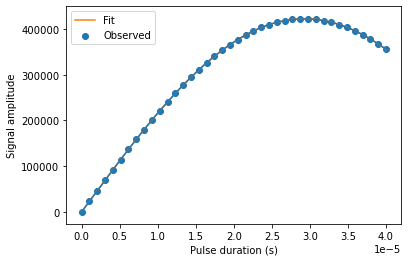

In [84]:
plt.scatter(t, amplitudes, label='Observed')
plt.errorbar(t, amplitudes, yerr=stds)
plt.plot(t, fit[0][0] * np.sin(fit[0][1] * t), label='Fit')
plt.legend()
plt.xlabel('Pulse duration (s)')
plt.ylabel('Signal amplitude')

In [85]:
t_pi2 = np.pi / (2 * estimates[1])
print(f'{t_pi2 : .04e}')  # estimate for pi/2 hard pulse length

 2.9295e-05


In [86]:
print(f'{t_pi2 * std_errs[1] / estimates[1] : 0.01e}')  # standard error for pi/2 hard pulse length

 9.0e-09


The estimate for a $\pi/2$ pulse is $29.292 \pm 0.009 \mu$s.

## Estimating T1

In [87]:
data_dir = '../data/2020-09-30/runs/'

In [88]:
amplitudes_t1 = np.zeros((100,))
stds_t1 = np.zeros((100,))
for i in range(100):
    data_p = read_processed(data_dir, 204 + i)
    amplitudes_t1[i] = np.sum(data_p[1])
    stds_t1[i] = np.std(data_p[1][:100]) * data_p[1].shape[0]

In [89]:
delays_t1 = np.linspace(10e-6, 2, 100)

In [90]:
fit_t1 = curve_fit(lambda t, a, tau, c: a * np.exp(-t / tau) + c,
                   xdata=delays_t1[delays_t1>.1],
                   ydata=amplitudes_t1[delays_t1>.1],
                   p0=(8e5, 1, -4e5),
                   sigma=stds_t1[delays_t1>.1])

In [91]:
estimates_t1 = fit_t1[0]
std_errs_t1 = np.sqrt(np.diag(fit_t1[1]))
print(estimates_t1)
print(std_errs_t1)

[ 7.78122351e+05  9.33273469e-01 -4.28242026e+05]
[1.07004230e+03 4.07108903e-03 1.43302632e+03]


Then the estimate for $T_1 = 0.933 \pm .004$s.

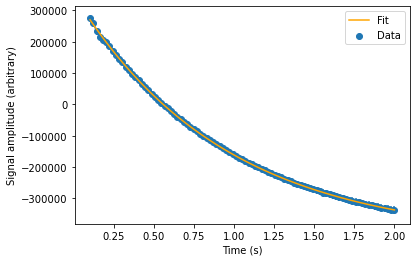

In [92]:
plt.scatter(delays_t1[delays_t1>.1],
            amplitudes_t1[delays_t1>.1],
            label='Data')
plt.errorbar(delays_t1[delays_t1>.1],
             amplitudes_t1[delays_t1>.1],
             yerr=stds_t1[delays_t1>.1])
plt.plot(delays_t1[delays_t1>.1],
         fit_t1[0][0] * np.exp(-delays_t1[delays_t1>.1] / fit_t1[0][1]) + fit_t1[0][2],
         color='orange',
         label='Fit',
         zorder=4,)
plt.xlabel('Time (s)')
plt.ylabel('Signal amplitude (arbitrary)')
plt.legend()

## Estimating T2

In [93]:
amplitudes_t2 = np.zeros((100,))
stds_t2 = np.zeros((100,))
for i in range(100):
    data_p = read_processed(data_dir, 305 + i)
    amplitudes_t2[i] = np.sum(data_p[1])
    stds_t2[i] = np.std(data_p[1][:100]) * data_p[1].shape[0]

In [94]:
delays_t2 = np.linspace(10e-6, 1.5, 100)

In [95]:
fit_t2 = curve_fit(lambda t, a, tau, c: a * np.exp(-t / tau) + c,
                   delays_t2[delays_t2>0.2], amplitudes_t2[delays_t2>0.2],
                   p0=(3e5, 1, 0),
                   sigma=stds_t2[delays_t2>0.2])

In [96]:
estimates_t2 = fit_t2[0]
std_errs_t2 = np.sqrt(np.diag(fit_t2[1]))
print(estimates_t2)
print(std_errs_t2)

[ 3.96292555e+05  3.28174027e-01 -1.51639856e+03]
[8.46280545e+02 8.48484997e-04 1.33282758e+02]


The estimate for $T_2 = 0.3282 \pm 0.0009$s.

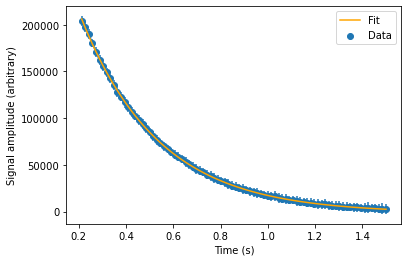

In [97]:
plt.scatter(delays_t2[delays_t2>0.2],
            amplitudes_t2[delays_t2>0.2],
            label='Data')
plt.errorbar(delays_t2[delays_t2>0.2],
             amplitudes_t2[delays_t2>0.2],
             yerr=stds_t2[delays_t2>0.2])
plt.plot(delays_t2[delays_t2>0.2],
         fit_t2[0][0] * np.exp(-delays_t2[delays_t2>0.2] / fit_t2[0][1]) + fit_t2[0][2],
         color='orange', zorder=4, label='Fit')
plt.xlabel('Time (s)')
plt.ylabel('Signal amplitude (arbitrary)')
plt.legend()